In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from tqdm import tqdm 

class Agent:
    def __init__(self, position, direction, speed):
        # Initialize agent's position, direction, and speed
        self.position = np.array(position)
        # Direction is represented as a unit vector
        self.unit_dir_vec = np.array([np.cos(direction), np.sin(direction)])
        # Desired direction for future movement, initially set to zero vector
        self.desire_direction = np.zeros_like(self.unit_dir_vec)
        self.speed = speed  # Movement speed of the agent
        # Color of the agent (assuming some visualization purpose)
        self.color = (0.0, 0.0, 1.0)  # Blue color
        # Maximum angle by which the agent can turn (5 degrees in radians)
        self.theta_max = 0.0872665
        # ZOR (Zone of Repulsion) influence vector
        self.d_r = np.zeros_like(self.unit_dir_vec)
        # ZOO (Zone of Orientation) influence vector
        self.d_o = np.zeros_like(self.unit_dir_vec)
        # ZOA (Zone of Attraction) influence vector
        self.d_a = np.zeros_like(self.unit_dir_vec)
        # Number of neighbors in each zone
        self.n_r = 0
        self.n_o = 0
        self.n_a = 0

    def update(self, space_size, dt):
        # Update the agent's direction towards its desired direction
        self.turn_towards_desire_direction()
        # Update the agent's position based on its current direction and speed
        self.position += self.unit_dir_vec * self.speed * dt

        # Handle boundary conditions to ensure the agent stays within the space
        if self.position[0] > space_size:
            self.position[0] = 0.0
        elif self.position[0] < 0.0:
            self.position[0] = space_size

        if self.position[1] > space_size:
            self.position[1] = 0.0
        elif self.position[1] < 0.0:
            self.position[1] = space_size

    def turn_towards_desire_direction(self):
        # Normalize current and desired direction vectors
        unit_v1 = self.unit_dir_vec / np.linalg.norm(self.unit_dir_vec)
        unit_v2 = self.desire_direction / np.linalg.norm(self.desire_direction)
        # Calculate the cosine of the angle between the current and desired directions
        cos_theta = np.dot(unit_v1, unit_v2)
        # Compute the angle in radians, clipped to handle numerical issues
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

        # Determine the direction of rotation (clockwise or counterclockwise)
        sign = np.sign(np.cross(self.unit_dir_vec, self.desire_direction))
        # Calculate the actual turn angle, limited by theta_max
        turn_angle = sign * min(angle, self.theta_max)
        # Create a rotation matrix for the computed turn angle
        rotation_matrix = np.array([[np.cos(turn_angle), -np.sin(turn_angle)],
                                    [np.sin(turn_angle), np.cos(turn_angle)]])
        # Rotate the current direction vector
        rotated_vec = np.dot(rotation_matrix, self.unit_dir_vec)
        # Normalize the rotated vector to maintain unit length
        self.unit_dir_vec = rotated_vec / np.linalg.norm(rotated_vec)

    def zor_update(self, r_ij):
        # Update Zone of Repulsion (ZOR) vector with the influence of neighbor j
        self.n_r += 1
        self.d_r += r_ij

    def zoo_update(self, v_j):
        # Update Zone of Orientation (ZOO) vector with the influence of neighbor j
        self.n_o += 1
        self.d_o += v_j

    def zoa_update(self, r_ij):
        # Update Zone of Attraction (ZOA) vector with the influence of neighbor j
        self.n_a += 1
        self.d_a += r_ij

    def evaluate_desire_direction(self, noise):
        # Determine the desired direction based on the zones
        if self.n_r > 0:
            # If there are neighbors in ZOR, repel (move away)
            d_i = -self.d_r
        elif self.n_o > 0 and self.n_a > 0:
            # If both ZOO and ZOA have neighbors, average their influences
            d_i = (self.d_o + self.d_a) * 0.5
        elif self.n_o > 0:
            # If only ZOO has neighbors, align with their direction
            d_i = self.d_o
        elif self.n_a > 0:
            # If only ZOA has neighbors, attract (move towards them)
            d_i = self.d_a
        else:
            # If no neighbors, continue in the current direction
            d_i = self.unit_dir_vec

        # Add random noise to the desired direction
        d_i += noise
        # Normalize the desired direction to maintain unit length
        norm = np.linalg.norm(d_i)
        if norm != 0:
            d_i /= norm

        # Update the desired direction
        self.desire_direction = d_i

import matplotlib.pyplot as plt
from tqdm import tqdm

class Swarm:
    def __init__(self, N, speed, space_size, sigma, rep_r, orien_r, attr_r, dt):
        # Initialize swarm parameters
        self.num_agents = N  # Number of agents in the swarm
        self.dt = dt  # Time step for the simulation
        self.space_size = space_size  # Size of the space in which the swarm operates
        self.sigma = sigma  # Standard deviation of the noise applied to agents' movement

        # Initialize agents
        self.agents = Swarm.__initialize_agent(N, speed, space_size)

        # Define radii for different zones of interaction
        self.repul_radius = rep_r  # Repulsion radius
        self.orien_radius = orien_r  # Orientation radius
        self.attrac_radius = attr_r  # Attraction radius

    def __initialize_agent(N, speed, space_size):
        # 中心点
        center = np.array([space_size / 2, space_size / 2])
        # 定义初始分布半径（比如空间边长的10%）
        radius = space_size * 0.1
        agents = []
        for _ in range(N):
            # 随机生成半径和角度，保证均匀分布在圆形区域
            r = np.random.uniform(0, radius)
            theta = np.random.uniform(0, 2 * np.pi)
            pos = center + r * np.array([np.cos(theta), np.sin(theta)])
            direction = np.random.rand() * 2 * np.pi
            agents.append(Agent(pos, direction, speed))
        return agents

    def reset_swarm(self):
        # Reset the forces and neighbor counts for each agent
        for agent in self.agents:
            agent.d_r = np.zeros_like(agent.unit_dir_vec)  # Reset repulsion force vector
            agent.d_o = np.zeros_like(agent.unit_dir_vec)  # Reset orientation force vector
            agent.d_a = np.zeros_like(agent.unit_dir_vec)  # Reset attraction force vector
            agent.n_r = 0  # Reset repulsion neighbors count
            agent.n_a = 0  # Reset attraction neighbors count
            agent.n_o = 0  # Reset orientation neighbors count

    def generate_noise(self, sigma):
        # Generate noise for the agent's direction, based on the provided sigma (standard deviation)
        return np.random.normal(0, sigma)

    def compute_polarization(self):
        """
        计算群体极化度，范围[0,1]，越接近1代表全体方向越一致
        """
        sum_dir = np.sum([agent.unit_dir_vec for agent in self.agents], axis=0)
        polarization = np.linalg.norm(sum_dir) / self.num_agents
        return polarization

    def compute_angular_momentum(self):
        """
        计算群体归一化角动量（范围在0~1之间，表示方向绕质心最大集体旋转时为1，没有旋转为0）
        """
        positions = np.array([agent.position for agent in self.agents])
        dirs = np.array([agent.unit_dir_vec for agent in self.agents])
        center_of_mass = np.mean(positions, axis=0)
        deltas = positions - center_of_mass
    
        # # 归一化 deltas（否则远离中心分量比近的更大，对群体角动量影响会大）
        # deltas_norm = np.linalg.norm(deltas, axis=1)
        # dirs_norm = np.linalg.norm(dirs, axis=1)
        # # 防止除零
        # norm_factor = deltas_norm * dirs_norm
        # norm_factor[norm_factor == 0] = 1
    
        # 单位化后的叉积
        unit_cross = deltas[:, 0] * dirs[:, 1] - deltas[:, 1] * dirs[:, 0]
        unit_cross = unit_cross / np.abs(unit_cross).max()
        #import pdb; pdb.set_trace()
        normalized_angular_momentum = np.linalg.norm(np.sum(unit_cross)) / self.num_agents
        return normalized_angular_momentum

        
    def simulate(self):
        # Simulate one time step for all agents
        self.reset_swarm()  # Reset the forces and neighbor counts

        for agent in self.agents:
            c_i = agent.position  # Current position of the agent
            for other_agent in self.agents:
                c_j = other_agent.position  # Position of another agent
                r_ij = (c_j - c_i)  # Vector from agent to another agent
                distance = np.linalg.norm(r_ij)  # Euclidean distance between the two agents
                distances = np.minimum(distance, self.space_size - distance)  # Handle edge cases by wrapping around

                if distance != 0:  # If distance is not zero (to avoid division by zero)
                    r_ij /= distance  # Normalize the distance vector
                    if distance < self.repul_radius:
                        agent.zor_update(r_ij)  # Update agent behavior if within the repulsion radius
                    else:
                        v_j = other_agent.unit_dir_vec  # Direction vector of the other agent
                        if distance >= self.repul_radius and distance < self.orien_radius:
                            agent.zoo_update(v_j)  # Update agent behavior if within the orientation radius
                        elif distance >= self.orien_radius and distance < self.attrac_radius:
                            agent.zoa_update(r_ij)  # Update agent behavior if within the attraction radius

            if agent.n_o > 0:
                agent.d_o /= (agent.n_o + 1)  # Average orientation direction if there are orientation neighbors

            noise = self.generate_noise(self.sigma)  # Generate noise to add to the agent's direction
            agent.evaluate_desire_direction(noise)  # Calculate the desired direction considering all forces

        for agent in self.agents:
            agent.update(self.space_size, self.dt)  # Update the agent's position based on its desired direction

class Simulation:
    def __init__(self, num_agent=100, speed=2.0, space_size=100, sigma=0.1, rep_r=3, orien_r=7, attr_r=12, dt=1.0):
        # 初始化群体
        self.rep_r = rep_r
        self.ori_r = orien_r
        self.att_r = attr_r
        self.swarm = Swarm(num_agent, speed, space_size, sigma, rep_r, orien_r, attr_r, dt)
        self.num_agent = num_agent

    def run(self, steps=100, radius_change_step=3000, 
            new_ori_r=None, new_att_r=None):
        # Use new radii if provided, else keep original values
        new_ori_r = self.ori_r if new_ori_r is None else new_ori_r
        new_att_r = self.att_r if new_att_r is None else new_att_r

        polarization_list = []
        angular_momentum_list = []
        trajectories = [[] for _ in range(self.num_agent)]

        for step in tqdm(range(steps)):
            # Update radii based on current step
            if step < radius_change_step:
                # First phase parameters
                current_ori_r = self.ori_r
                current_att_r = self.att_r
            else:
                # Second phase parameters
                current_ori_r = new_ori_r
                current_att_r = new_att_r
                
            # Apply current zone radii to swarm
            self.swarm.orien_radius = current_ori_r
            self.swarm.attrac_radius = current_att_r
            
            # Record metrics and positions
            polarization = self.swarm.compute_polarization()
            angular_momentum = self.swarm.compute_angular_momentum()
            polarization_list.append(polarization)
            angular_momentum_list.append(angular_momentum)
            
            for idx, agent in enumerate(self.swarm.agents):
                trajectories[idx].append(agent.position.copy())
            
            # Run simulation step
            self.swarm.simulate()

        return (
            [np.array(traj) for traj in trajectories],
            polarization_list,
            angular_momentum_list
        )

        

N = 30
sim = Simulation(
    num_agent=N,
    speed=1.0,
    space_size=150,
    sigma=0.1,
    rep_r=5,
    orien_r=30,  # Initial orientation radius
    attr_r=32,    # Initial attraction radius
    dt=0.1
)

# Run with 10000 steps: first 3000 steps use initial radii, last 7000 use new values
trajectories, pol, ang_mom = sim.run(
    steps=10000,
    radius_change_step=3000,
    new_ori_r=50,  # New orientation radius after 3000 steps
    new_att_r=60    # New attraction radius after 3000 steps
)

100%|██████████| 10000/10000 [02:03<00:00, 81.05it/s]


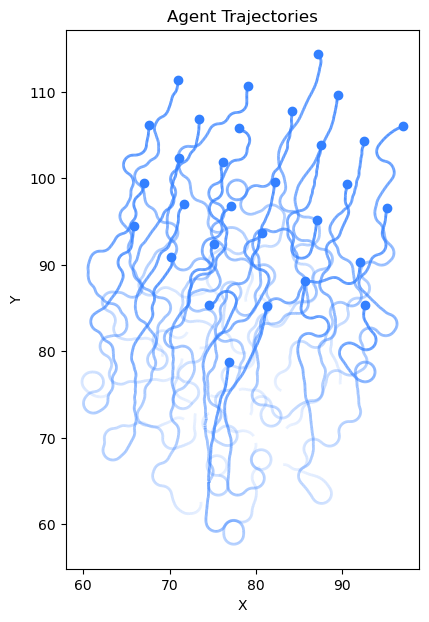

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_trajectories_with_time_alpha(trajectories):
    """
    trajectories: List of shape [N_agents][steps, 2]
    """
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    
    for traj in trajectories:
        # 每个轨迹分成steps-1个线段
        points = traj.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        n_steps = len(traj)
        # 计算每个线段的透明度，时间越大越不透明
        # 例如alpha从0.1递增到1.0
        alphas = np.linspace(0.1, 1.0, n_steps-1)
        # 每个线段一个颜色，alpha不同
        colors = np.zeros((n_steps-1, 4))
        colors[:, 0] = 0.2  # 红色分量
        colors[:, 1] = 0.5  # 绿色分量
        colors[:, 2] = 1.0  # 蓝色分量
        colors[:, 3] = alphas  # alpha分量

        lc = LineCollection(segments, colors=colors, linewidths=2)
        ax.add_collection(lc)

        # 可选：画出最后一点
        ax.plot(traj[-1,0], traj[-1,1], 'o', color=(0.2,0.5,1.0), markersize=6)

    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Agent Trajectories')
    plt.show()


plot_trajectories_with_time_alpha(trajectories)


100%|██████████| 10000/10000 [02:12<00:00, 75.21it/s]


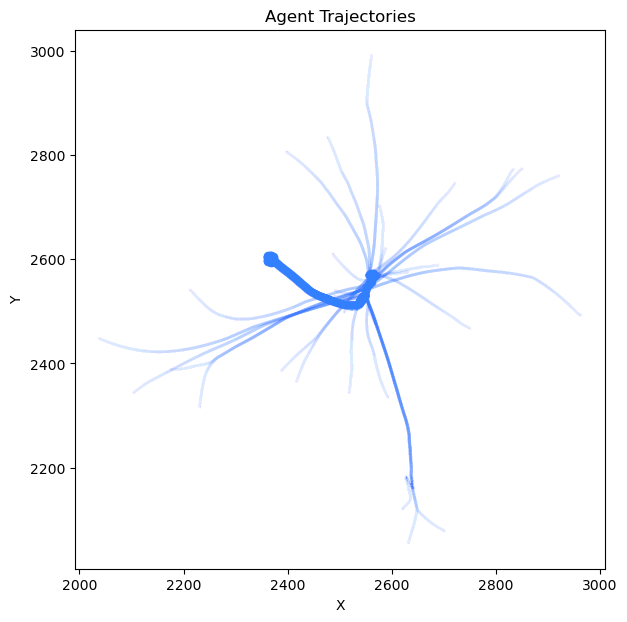

[0.23993285777702336, 0.26404725124992756, 0.2763944303828871, 0.3001720010316735, 0.32587589654855553, 0.34696429813334073, 0.3652130903937206, 0.39304475199545114, 0.41159578588511736, 0.4330102700461328, 0.4575111242358313, 0.47688500028188047, 0.4968259387992552, 0.5251167761529829, 0.5464579898498478, 0.5709660268620456, 0.5917922387666628, 0.6099166210974106, 0.6224312659806047, 0.6353993667364467, 0.650513836555715, 0.6628505202855861, 0.6842271412352088, 0.7026683445944146, 0.723076892868312, 0.7462503379538189, 0.7668579933741566, 0.7851772491531435, 0.7964475264719783, 0.8053157028372162, 0.8228648203510198, 0.8374433336680145, 0.8492414808428328, 0.858347475646499, 0.8721155985519615, 0.8837677827741695, 0.8939707118952789, 0.9009481046354044, 0.9100087977279226, 0.9170347015366092, 0.9286412695415576, 0.9380345098125159, 0.9463829865652872, 0.952772969668665, 0.9590737939905998, 0.9636637845871799, 0.9664035625990913, 0.9674321176657615, 0.9675339332507332, 0.96617725770940

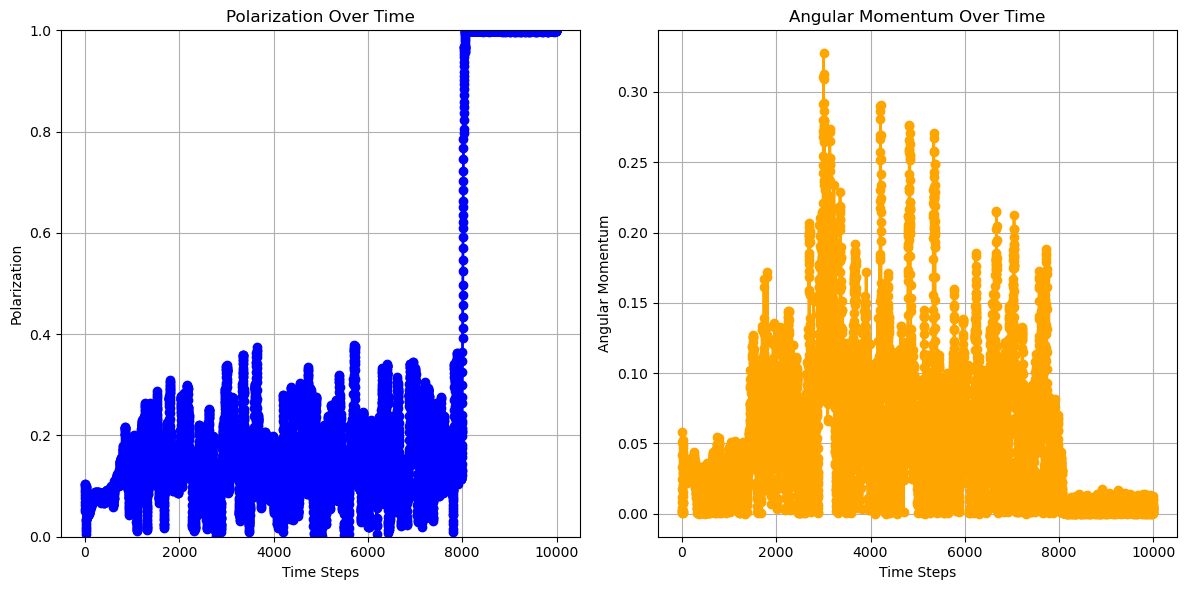

In [24]:
import random
def main(N, speed, space_size, sigma,  r_ori, r_att, r_ori_new, r_att_new, dt, r_rep=1, steps_all=10000, step_change=3000):
    sim = Simulation(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt)
    trajectories, pol, ang_mom = sim.run(
    steps=steps_all,
    radius_change_step=step_change,
    new_ori_r=r_ori_new,  # New orientation radius after 3000 steps
    new_att_r=r_att_new)
    plot_trajectories_with_time_alpha(trajectories)
    # 绘制极化度和角动量
    plt.figure(figsize=(12, 6))
    
    # 绘制极化度
    plt.subplot(1, 2, 1)
#     print(pol[8000:])
    plt.plot(pol, color='blue', linewidth=2, marker='o')
    plt.title("Polarization Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Polarization")
    plt.ylim(0, 1)  # 极化度范围在[0, 1]
    plt.grid()
    
    # 绘制角动量
    plt.subplot(1, 2, 2)
    plt.plot(ang_mom, color='orange', linewidth=2, marker='o')
    plt.title("Angular Momentum Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Angular Momentum")
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return trajectories

N = 30       # Number of agents in the swarm
r_rep = 1    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 1
r_ori_new = 30
r_att = 300   
r_att_new =300 
speed = 1.0  # Speed at which agents move
sigma = 0.05  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 5000  # Size of the 2D space in which the agents move
steps_all=10000
step_change=8000

seed=2050
random.seed(seed)
np.random.seed(seed)
trajectories = main(N, speed, space_size, sigma,  r_ori, r_att, r_ori_new, r_att_new, dt, steps_all=steps_all, step_change=step_change)

In [21]:
trajectories_swarm = np.array(trajectories)
trajectories_swarm = trajectories_swarm.transpose(1,0,2).reshape(steps_all, -1)
data_mean_df = pd.DataFrame(trajectories_swarm)
data_mean_df.columns = [f'C{v:02d}' for v in range(data_mean_df.shape[1])]
data_mean_df = data_mean_df.reset_index()              
#r_ori - r_att - agents - steps 
data_mean_df.to_csv('../dataset/Couzin/swarm_10000.csv', index=False, float_format='%.4f')

100%|██████████| 5000/5000 [00:36<00:00, 137.44it/s]


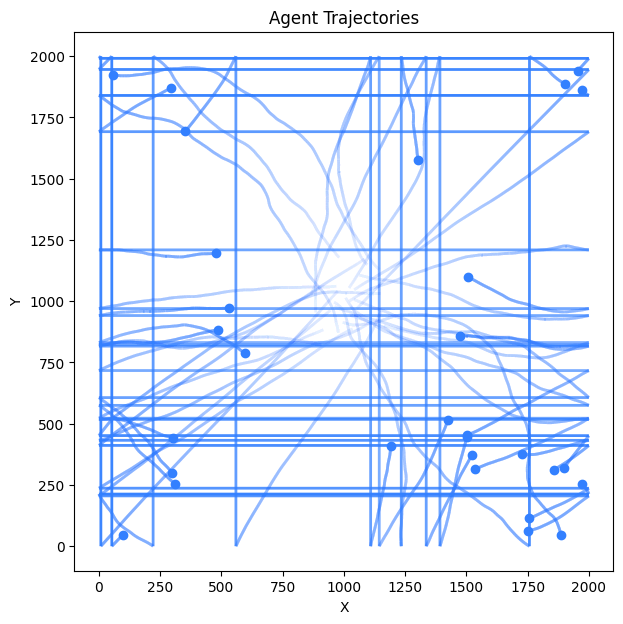

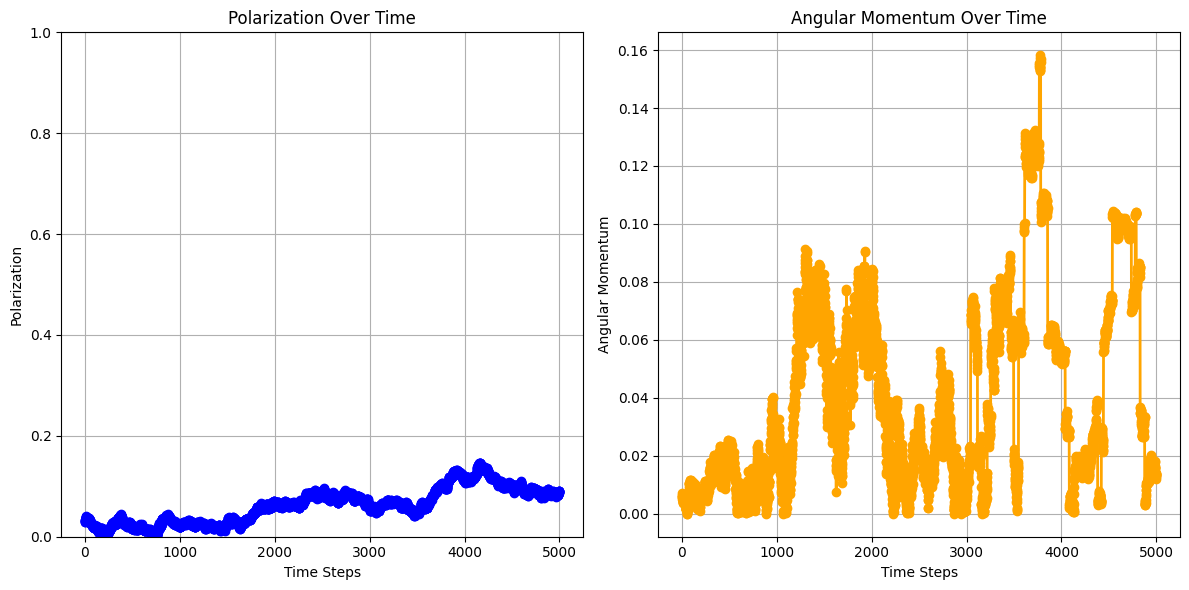

3580.212041997717


100%|██████████| 5000/5000 [00:37<00:00, 134.64it/s]


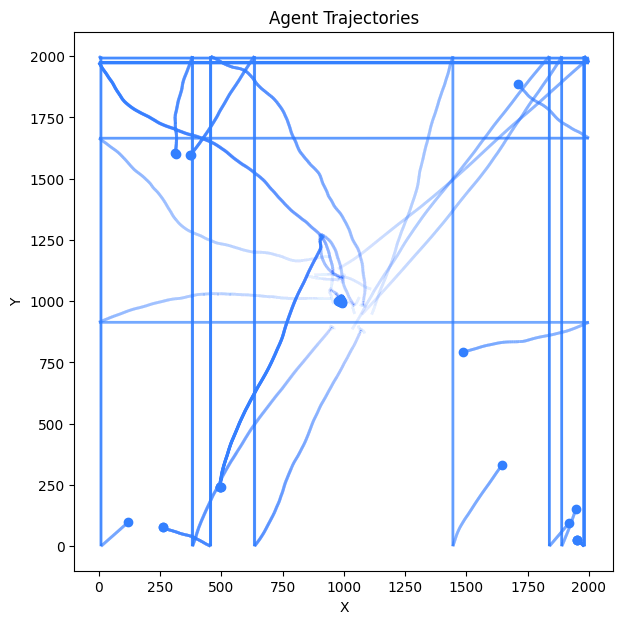

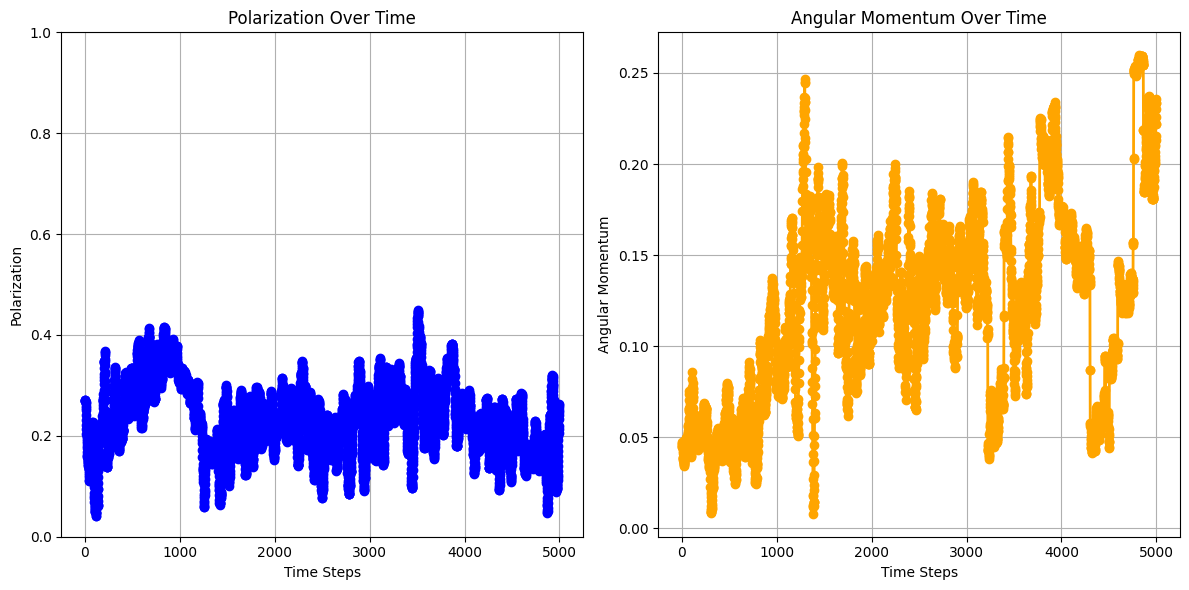

2517.3447392280814


100%|██████████| 5000/5000 [00:37<00:00, 135.04it/s]


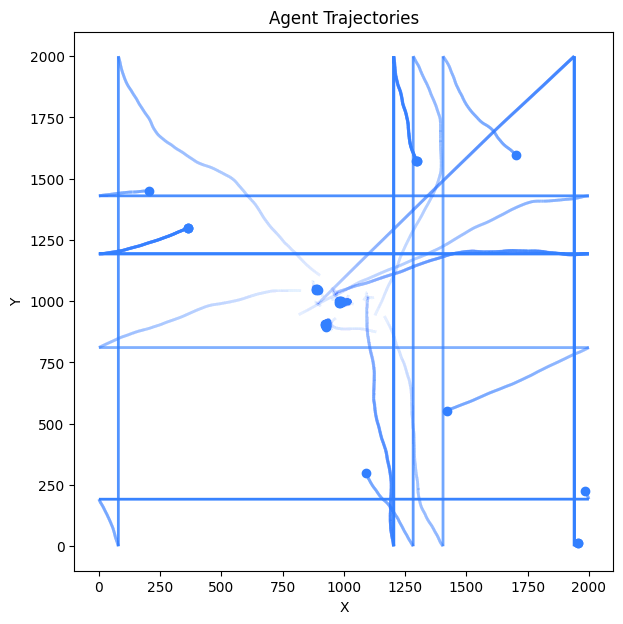

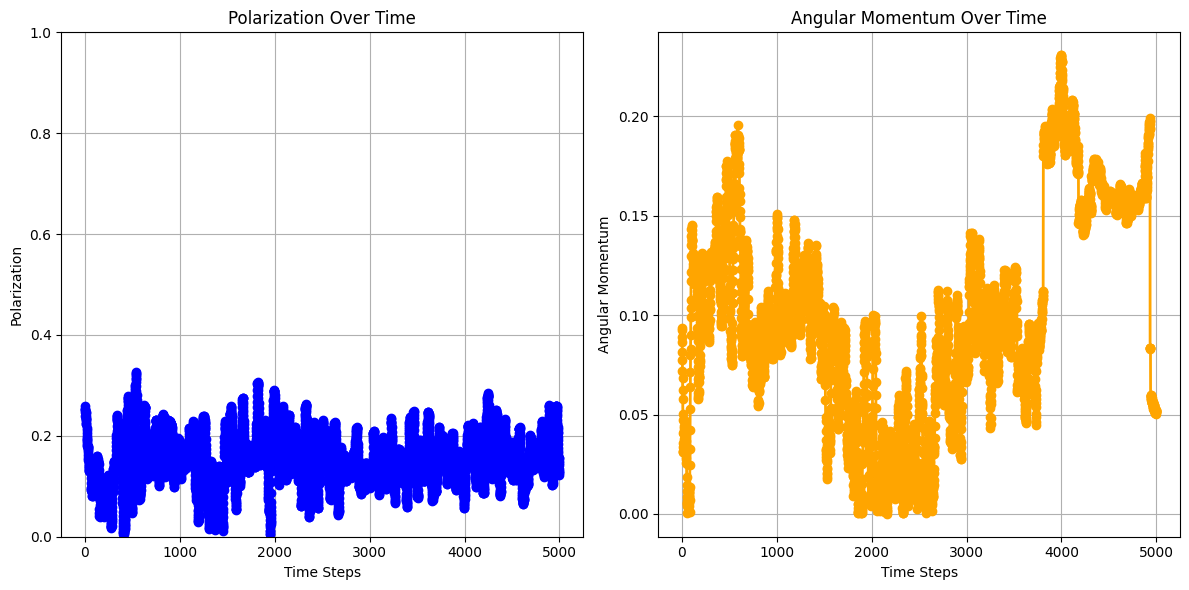

2269.0324569191753


100%|██████████| 5000/5000 [00:38<00:00, 129.77it/s]


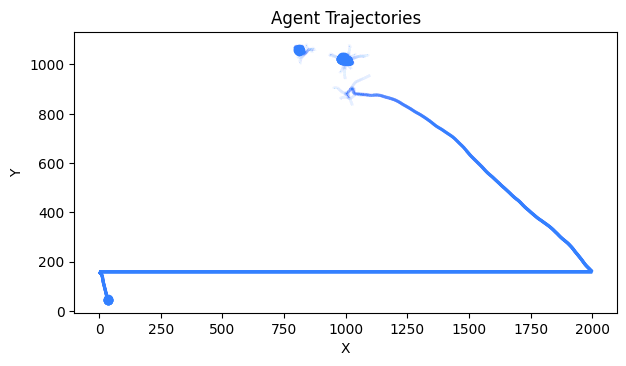

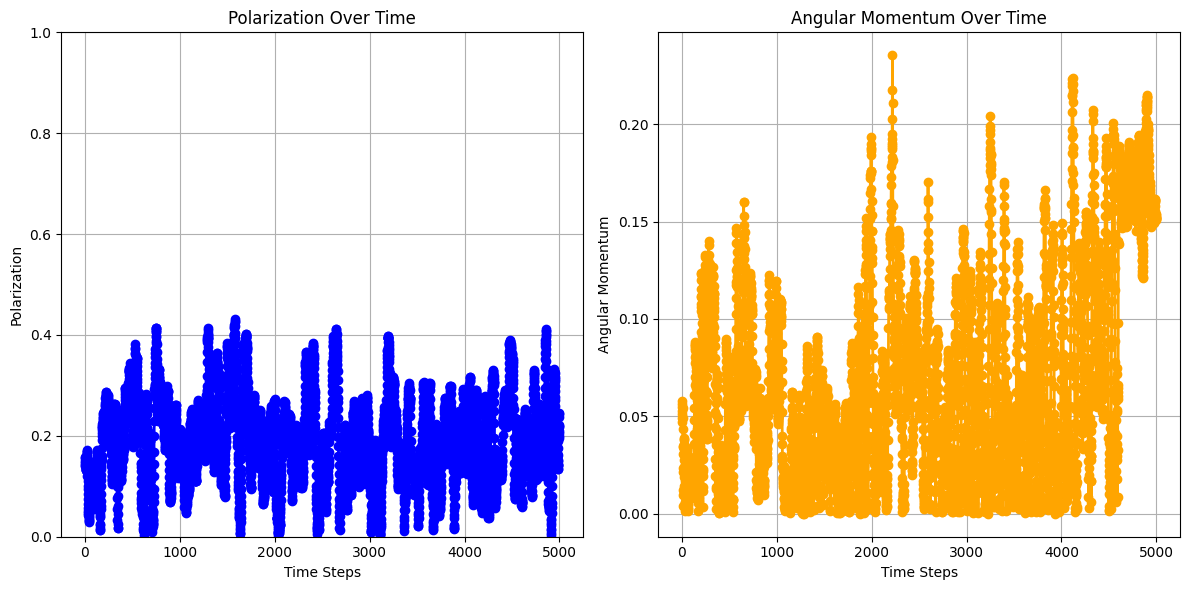

985.3130893355839


100%|██████████| 5000/5000 [00:39<00:00, 126.58it/s]


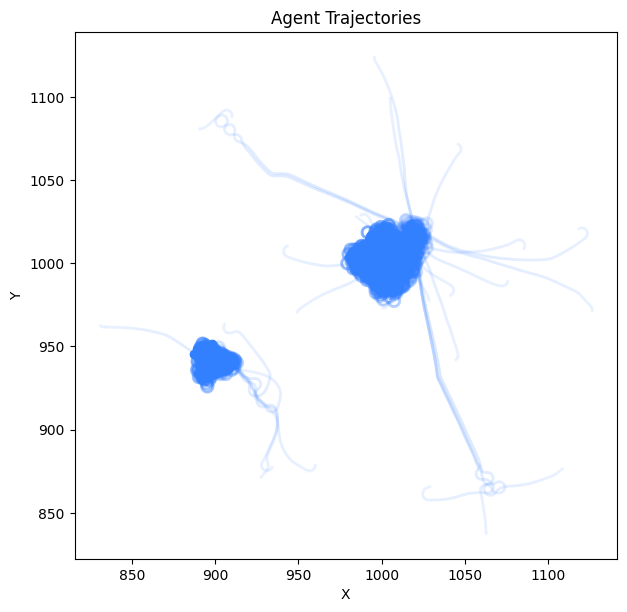

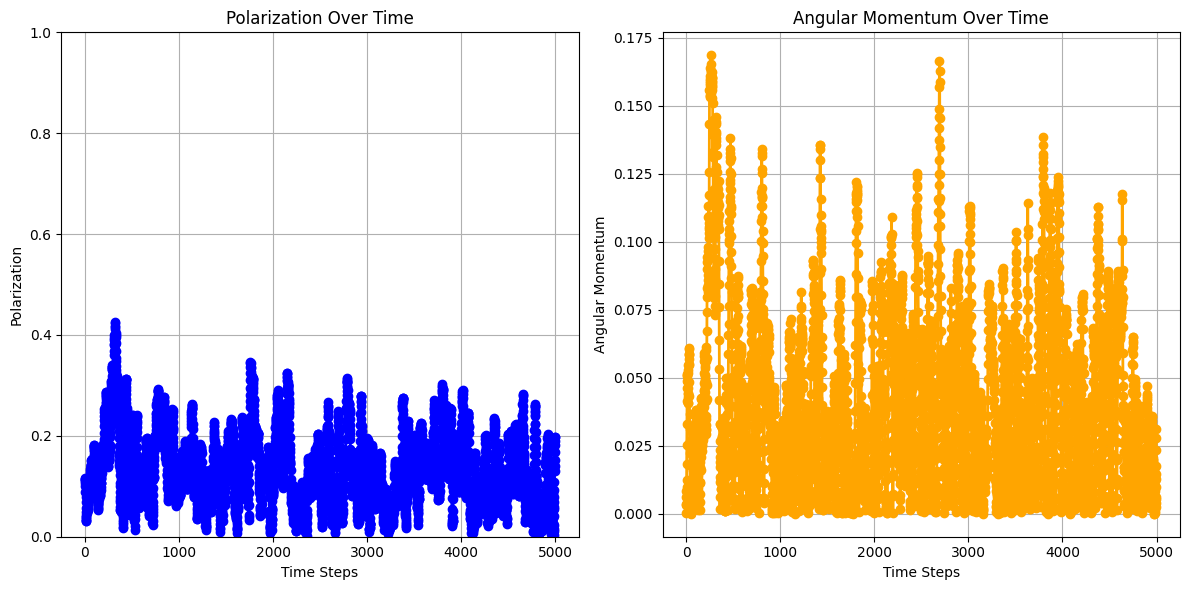

59.18734819393568


100%|██████████| 5000/5000 [00:39<00:00, 126.69it/s]


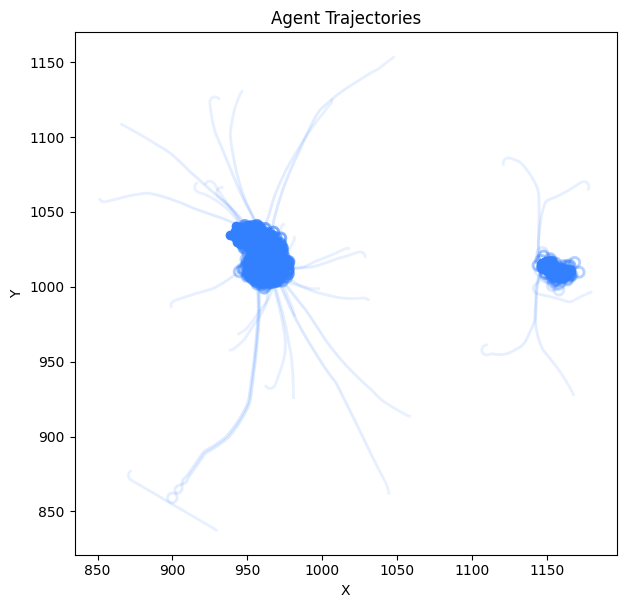

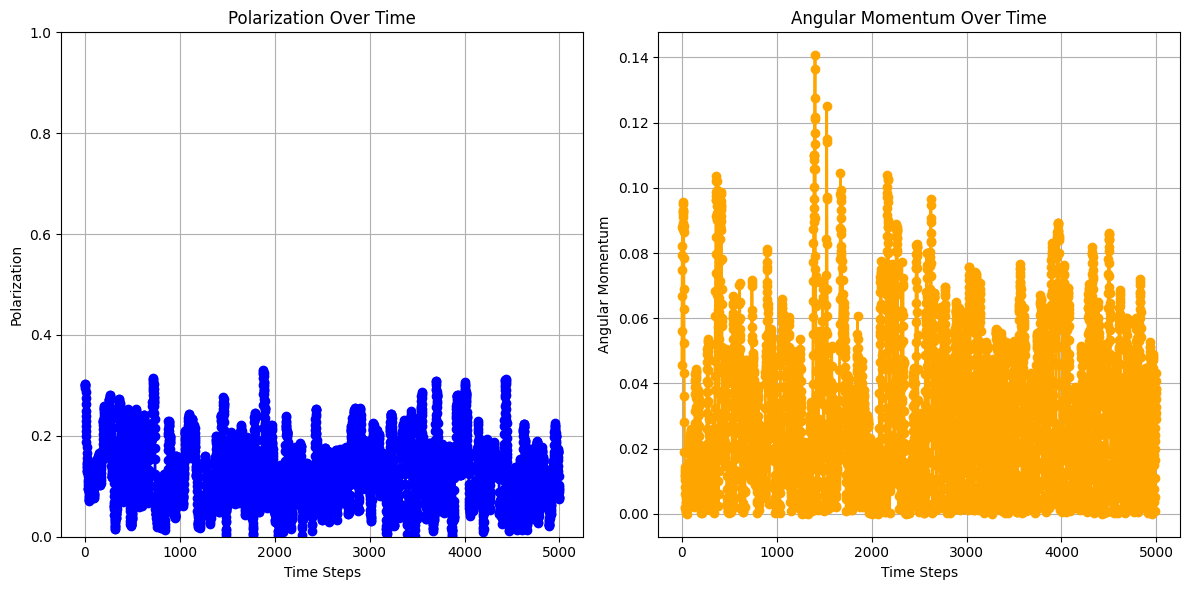

55.85456932665639


100%|██████████| 5000/5000 [00:40<00:00, 123.51it/s]


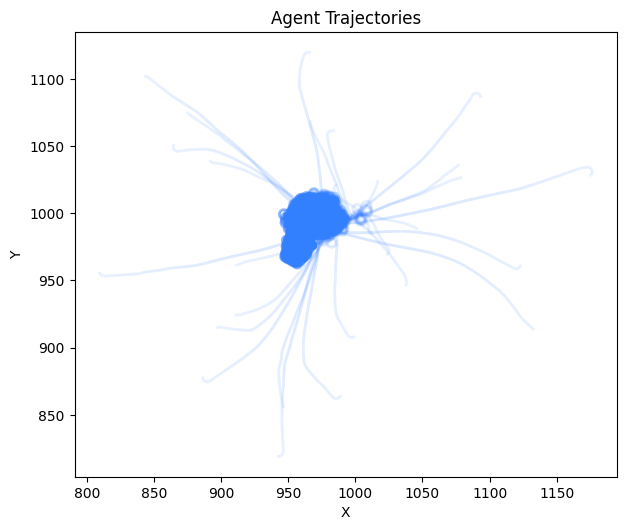

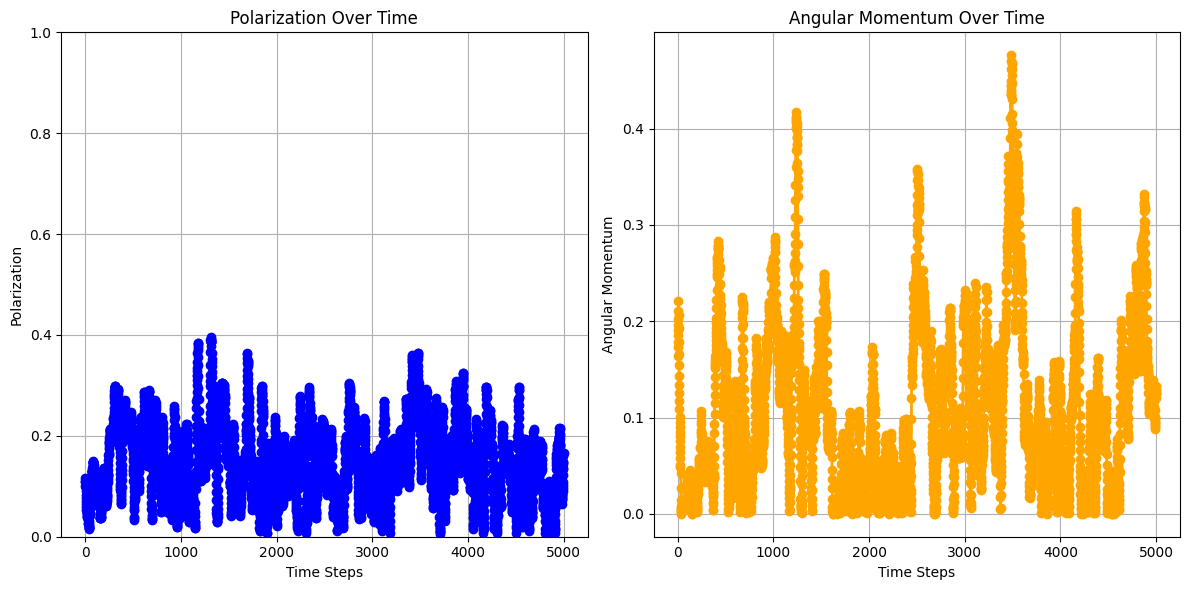

82.2275334995326


100%|██████████| 5000/5000 [00:40<00:00, 123.39it/s]


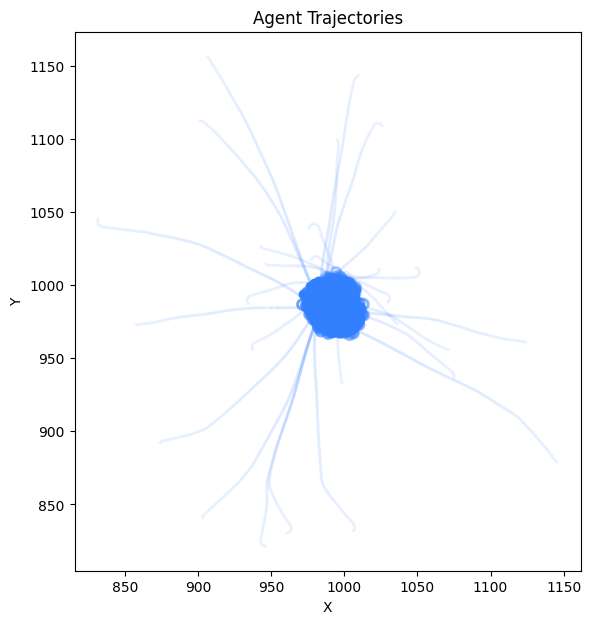

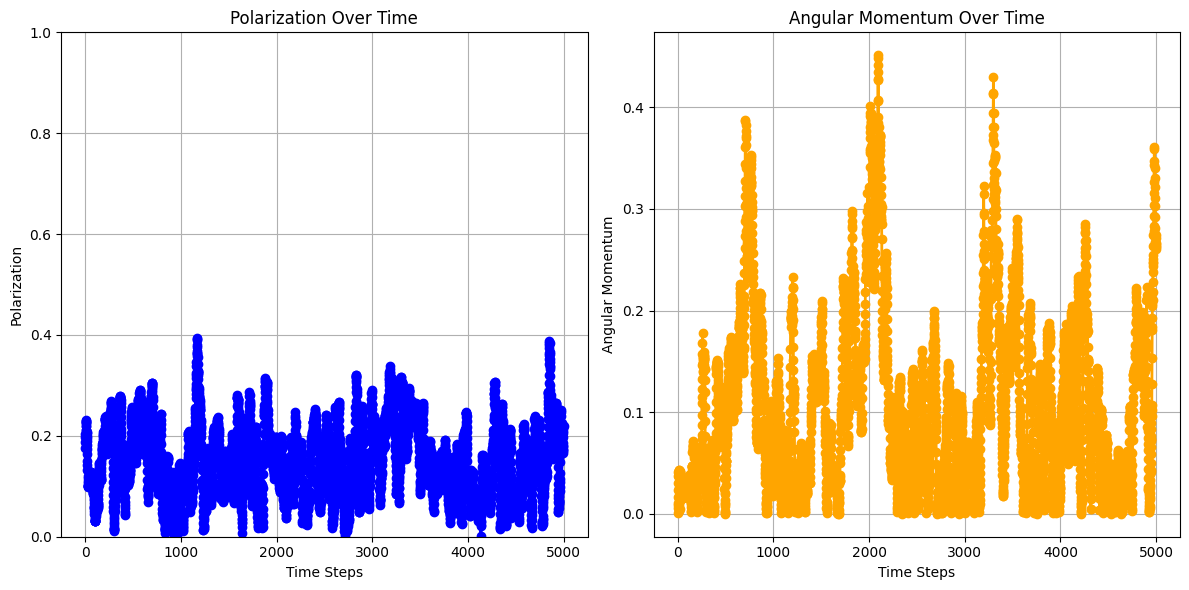

65.89930809554298


100%|██████████| 5000/5000 [00:40<00:00, 124.45it/s]


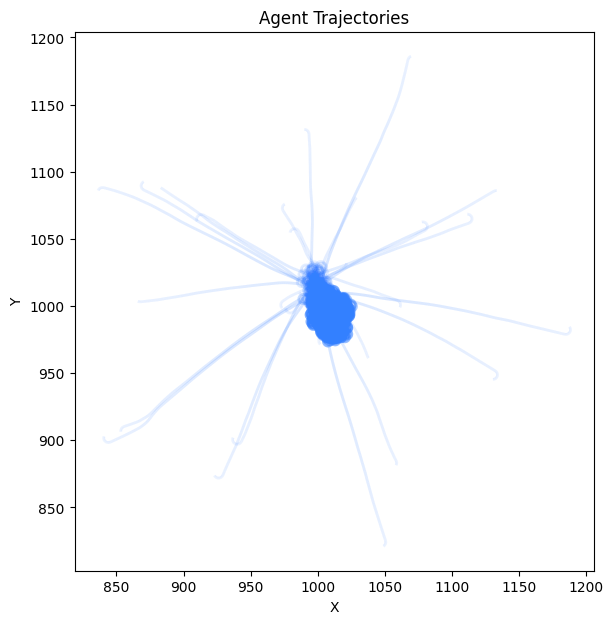

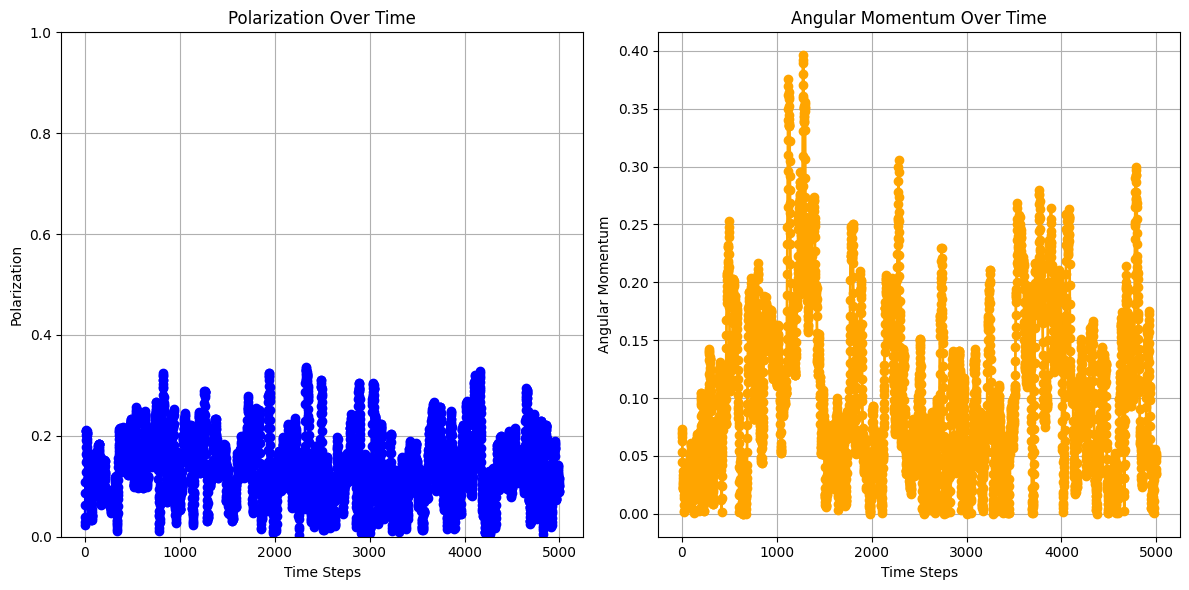

57.623968216551305


100%|██████████| 5000/5000 [00:40<00:00, 124.27it/s]


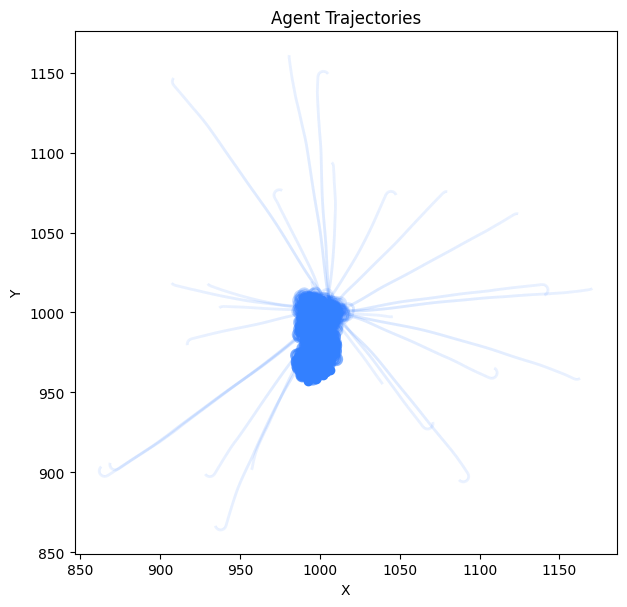

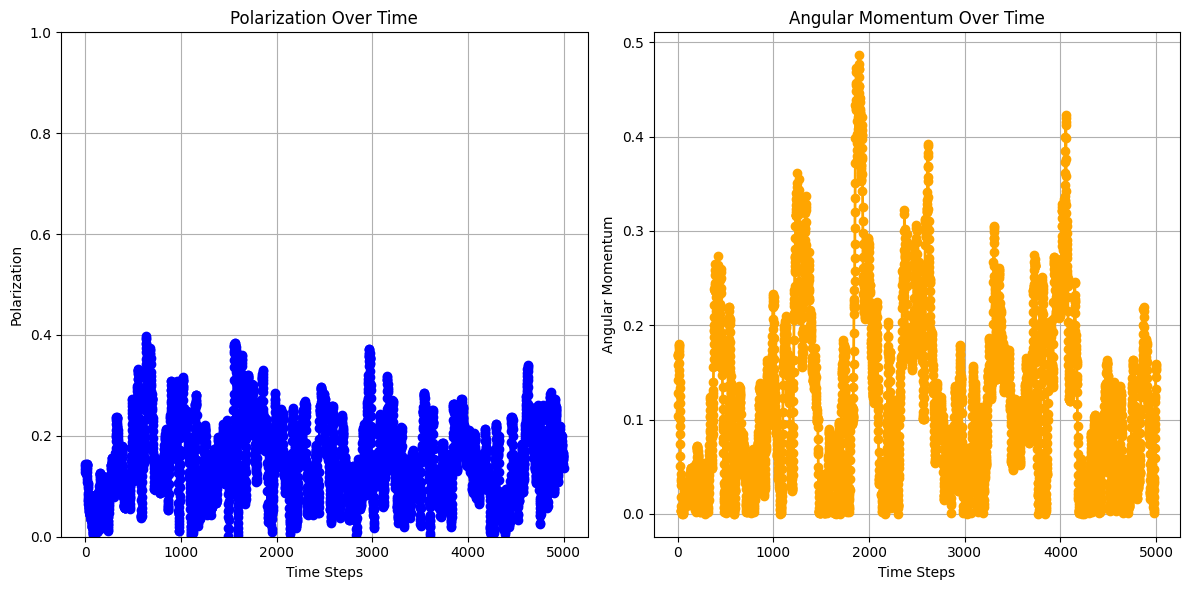

69.77308261574655


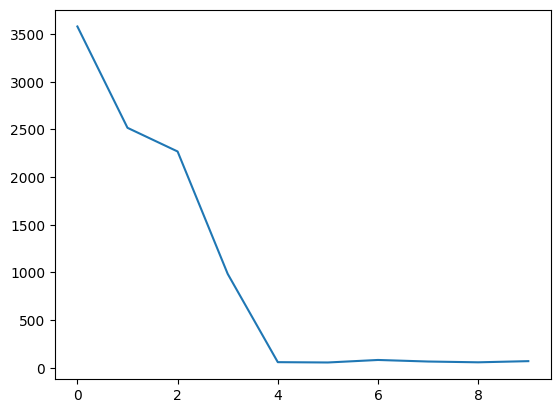

In [12]:
import random
N = 30       # Number of agents in the swarm
r_rep = 1    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 2  #12 
r_att = 100   # Radius of attraction (agents are attracted to others within this distance)
speed = 3.0  # Speed at which agents move
sigma = 0.01  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 2000  # Size of the 2D space in which the agents move
steps = 5000
dis_ls = []

for r_att in [1,20,30,60,80,100,120,140,160,200]:
    seed=2050
    random.seed(seed)
    np.random.seed(seed)
    trajectories_swarm = main(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt, steps)
    trajectories_swarm = np.array(trajectories_swarm)
    trajectories_swarm = trajectories_swarm.transpose(1,0,2).reshape(steps, -1)
    points = trajectories_swarm[1000:, :]
    center = np.mean(points, axis=0)
    distances = np.linalg.norm(points - center, axis=1)
    print(np.mean(distances))
    dis_ls.append(np.mean(distances))
    # data_mean_df = pd.DataFrame(trajectories_swarm)
    # data_mean_df.columns = [f'C{v:02d}' for v in range(data_mean_df.shape[1])]
    # data_mean_df = data_mean_df.reset_index()  
    # data_mean_df.to_csv('../dataset/Couzin/swarm_2_{0}_30_10000.csv'.format(r_att), index=False, float_format='%.4f')

plt.plot(dis_ls)

Text(0, 0.5, 'Clustering degree')

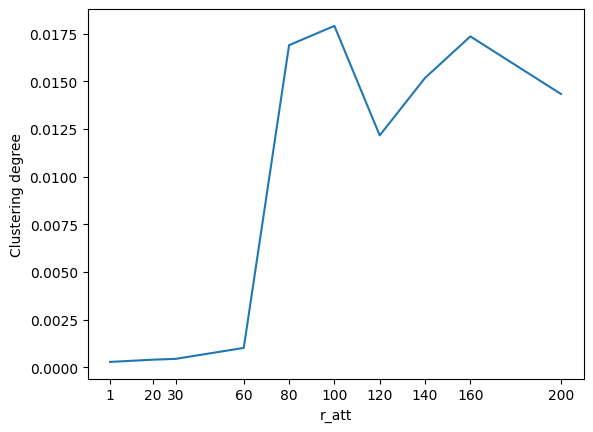

In [13]:
att_ls = [1,20,30,60,80,100,120,140,160,200]
swarm_ls = [1/i for i in dis_ls]
plt.figure()
plt.plot(att_ls, swarm_ls)
plt.xticks(att_ls)
plt.xlabel('r_att')
plt.ylabel('Clustering degree')

In [13]:
trajectories_swarm = np.array(trajectories_swarm)
trajectories_swarm = trajectories_swarm.transpose(1,0,2).reshape(steps, -1)
data_mean_df = pd.DataFrame(trajectories_swarm)
data_mean_df.columns = [f'C{v:02d}' for v in range(data_mean_df.shape[1])]
data_mean_df = data_mean_df.reset_index()              
#r_ori - r_att - agents - steps 
data_mean_df.to_csv('../dataset/Couzin/swarm_2_100_30_10000.csv', index=False, float_format='%.4f')

      index          C00          C01          C02          C03          C04  \
0         0   801.984057  1010.800959  1026.830832  1099.315515   916.752610   
1         1   802.265488  1010.904866  1026.633116  1099.541143   916.607100   
2         2   802.551565  1010.995198  1026.416488  1099.748682   916.439278   
3         3   802.837418  1011.086236  1026.182596  1099.936550   916.250422   
4         4   803.124387  1011.173695  1025.933220  1100.103318   916.041969   
...     ...          ...          ...          ...          ...          ...   
9995   9995  1025.560363   988.955258  1026.590012   984.188324  1032.524545   
9996   9996  1025.807953   989.124667  1026.463221   984.460214  1032.488750   
9997   9997  1026.069365   989.271853  1026.313215   984.720019  1032.427131   
9998   9998  1026.342611   989.395695  1026.141137   984.965761  1032.340157   
9999   9999  1026.625610   989.495251  1025.948296   985.195570  1032.228491   

             C05          C06          